# Fine-tune SAM on satellite images

## Load dataset


In [1]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

Found cached dataset satellite-building-segmentation (/h/vkhazaie/.cache/huggingface/datasets/keremberke___satellite-building-segmentation/full/1.0.0/2d4f5155d8a688bdff0915214924fbee078bcc85eb80f4d3c5884b8e319ec0ea)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6764
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1934
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 967
    })
})

We can visualize an example:

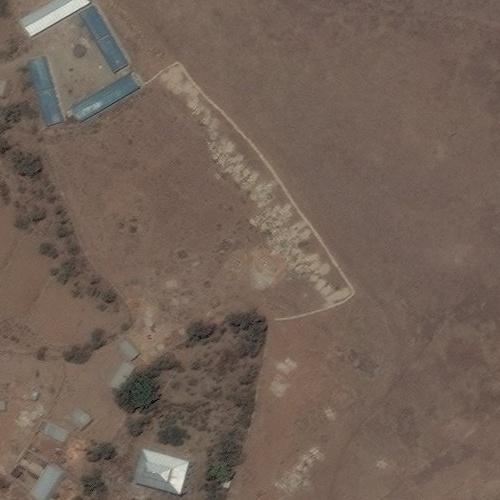

In [3]:
example = dataset['train'][0]
image = example["image"]
image

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask

def get_segmentation_mask(segmentation_label):
    # Convert COCO segmentation label to binary mask
    binary_mask= np.zeros((500, 500, 1))
    for seg_lbl in segmentation_label['segmentation']:
        rle = coco_mask.frPyObjects(seg_lbl, 500, 500)
        binary_mask += coco_mask.decode(rle)
    
    return binary_mask

In [5]:
mask = get_segmentation_mask(dataset["train"]["objects"][0])

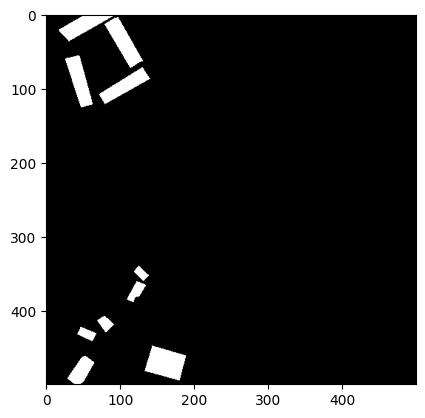

In [6]:
plt.imshow(mask, cmap="gray")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def show_bounding_boxes(image, bounding_boxes):
    # Create a figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot bounding boxes
    for bbox in bounding_boxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Configure plot settings
    ax.axis('off')
    plt.show()

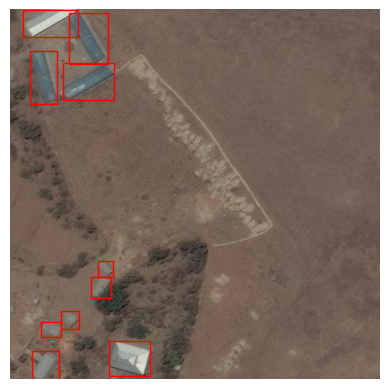

In [8]:
show_bounding_boxes(dataset["train"]["image"][0], dataset["train"]["objects"][0]['bbox'])

## Load the model

In [9]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda'

from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

In [10]:
from torch.utils.data import Dataset
from segment_anything.utils.transforms import ResizeLongestSide
import torch

class SAMDataset(Dataset):
    def __init__(self, dataset, preprocess, img_size, device):
        self.dataset = dataset
        self.preprocess = preprocess
        self.img_size = img_size
        self.device = device

    def __len__(self):
        return len(self.dataset)


    def convert_bboxes(self, bboxes):
        converted_bboxes = []
        for bbox in bboxes:
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            converted_bboxes.append([x_min, y_min, x_max, y_max])
        return np.array(converted_bboxes)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = np.array(item["image"])
        
        # # prepare the image for the model
        transform = ResizeLongestSide(self.img_size)
        input_image = transform.apply_image(image)
        input_image = torch.as_tensor(input_image, device=self.device)
        input_image = input_image.permute(2, 0, 1).contiguous()[None, :, :, :]

        input_image = self.preprocess(input_image).squeeze()
#         original_image_size = image.shape[0]
        input_size = tuple(input_image.shape[-2:])

        # prepare the prompt for the model
        box_prompt = np.array(item['objects']['bbox']).astype('float32')
        box_prompt = self.convert_bboxes(box_prompt)
        box_prompt = torch.as_tensor(box_prompt, device=self.device)
        
        # get the ground truth segmentation
        gt_mask = get_segmentation_mask(item["objects"]).reshape((1, 500, 500)).astype('float32')
        gt_mask = torch.as_tensor(gt_mask, device=self.device)
        
        inputs = {"image": input_image, "prompt": box_prompt, "gt_mask": gt_mask}

        return inputs

In [11]:
train_dataset = SAMDataset(dataset=dataset['train'], preprocess=sam.preprocess, img_size=sam.image_encoder.img_size, device=device)

In [12]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

image torch.Size([3, 1024, 1024])
prompt torch.Size([10, 4])
gt_mask torch.Size([1, 500, 500])


In [13]:
# for batch in train_dataset:
#     if batch['prompt'].shape[0] == 0: 
#         print(batch['prompt'].shape)

## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

image torch.Size([1, 3, 1024, 1024])
prompt torch.Size([1, 10, 4])
gt_mask torch.Size([1, 1, 500, 500])


## Train the model

In [36]:
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [37]:
from torch.nn.functional import threshold, normalize

In [38]:
import torch

from segment_anything.utils.transforms import ResizeLongestSide

In [39]:
def convert_bboxes(bboxes):
    converted_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        converted_bboxes.append([x_min, y_min, x_max, y_max])
    return np.array(converted_bboxes)


In [40]:
idx = 0

In [41]:
image = np.array(dataset["test"]["image"][idx])
prompt_box = np.array(dataset["test"]["objects"][idx]['bbox'])
prompt_box = convert_bboxes(prompt_box)

In [42]:
# No grad here as we don't want to optimise the encoders
with torch.no_grad():
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])
    
    image_embedding = sam.image_encoder(input_image)

    box = transform.apply_boxes(prompt_box, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
      points=None,
      boxes=box_torch,
      masks=None,
    )
    low_res_masks, iou_predictions = sam.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
    )

    upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
    binary_mask = binary_mask.sum(axis=0)

In [43]:
binary_mask = binary_mask.sum(axis=0)

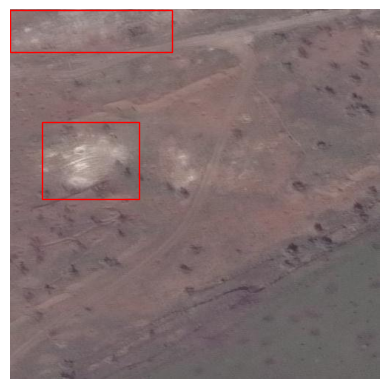

In [44]:
show_bounding_boxes(dataset["test"]["image"][idx], dataset["test"]["objects"][idx]['bbox'])

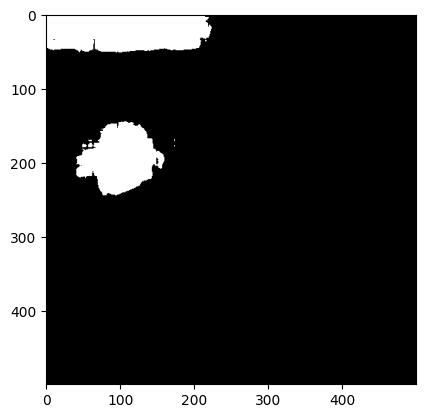

In [45]:
plt.imshow(binary_mask.detach().cpu().numpy().squeeze(), cmap='binary_r')

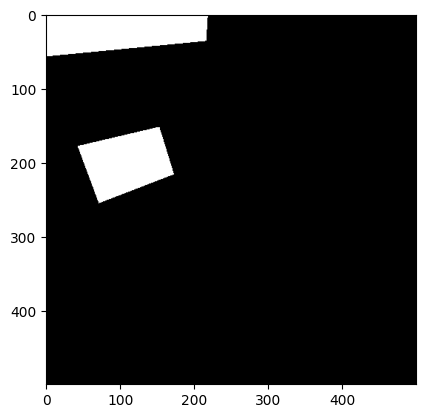

In [46]:
plt.imshow(get_segmentation_mask(dataset["test"]["objects"][0]), cmap="gray")

In [16]:
import monai
from torch.optim import Adam
import torch

optimizer = Adam(sam.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# seg_loss = loss = torch.nn.MSELoss()

In [17]:
from tqdm import tqdm
from statistics import mean
import torch
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize


num_epochs = 50

sam.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        if batch['prompt'].shape[1] == 0:
            continue
        
        # forward pass
        image_embedding = sam.image_encoder(batch['image'])

        sparse_embeddings, dense_embeddings = sam.prompt_encoder(
          points=None,
          boxes=batch['prompt'].reshape((-1, 4)),
          masks=None,
        )
        
        low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=image_embedding,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
        )

        upscaled_masks = sam.postprocess_masks(low_res_masks, batch['image'].shape[-2:], batch['gt_mask'].shape[-2:])
        binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
        binary_mask = binary_mask.sum(axis=0).unsqueeze(0)


        loss = seg_loss(binary_mask, batch['gt_mask'])

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  1%|          | 53/6764 [00:58<2:03:48,  1.11s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 14.76 GiB total capacity; 12.34 GiB already allocated; 349.75 MiB free; 13.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [18]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [19]:
def convert_bboxes(bboxes):
    converted_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        converted_bboxes.append([x_min, y_min, x_max, y_max])
    return np.array(converted_bboxes)

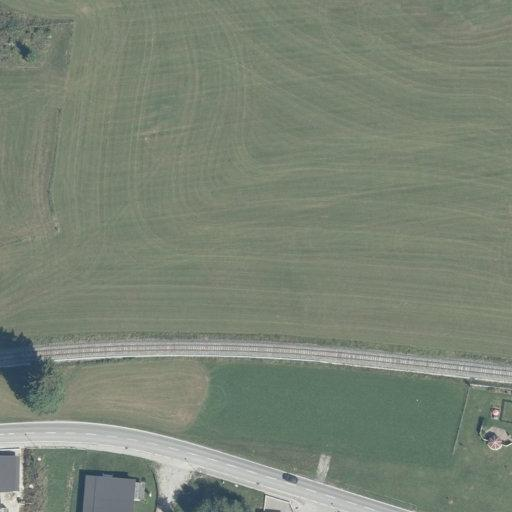

In [20]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 1

# load image
image = dataset['test'][idx]["image"]
image

In [21]:
sam.eval()

image = np.array(image)
ground_truth_mask = np.array(get_segmentation_mask(dataset['test'][idx]['objects']))
prompt = np.array(dataset['test'][idx]['objects']['bbox'])
prompt = convert_bboxes(prompt)

# No grad here as we don't want to optimise the encoders
with torch.no_grad():
    transform = ResizeLongestSide(sam.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])
    
    image_embedding = sam.image_encoder(input_image)

    box = transform.apply_boxes(prompt, original_image_size)
    box_torch = torch.as_tensor(box, dtype=torch.float, device=device)

    sparse_embeddings, dense_embeddings = sam.prompt_encoder(
      points=None,
      boxes=box_torch,
      masks=None,
    )
    low_res_masks, iou_predictions = sam.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False,
    )

    upscaled_masks = sam.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
    binary_mask = binary_mask.sum(axis=0)

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 14.76 GiB total capacity; 12.38 GiB already allocated; 349.75 MiB free; 13.48 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

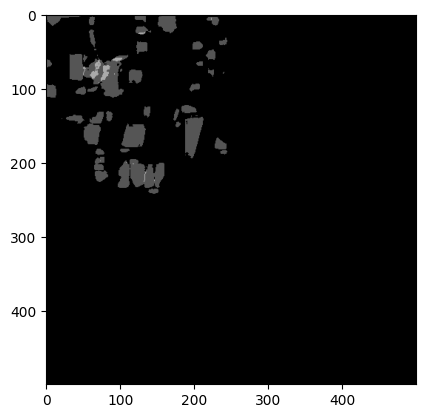

In [22]:
plt.imshow(binary_mask.detach().cpu().numpy().squeeze(), cmap='binary_r')

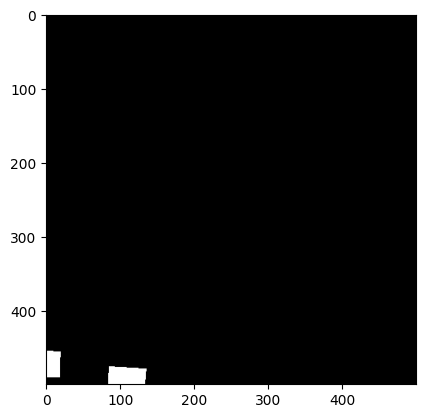

In [23]:
plt.imshow(ground_truth_mask, cmap="gray")

(-0.5, 499.5, 499.5, -0.5)

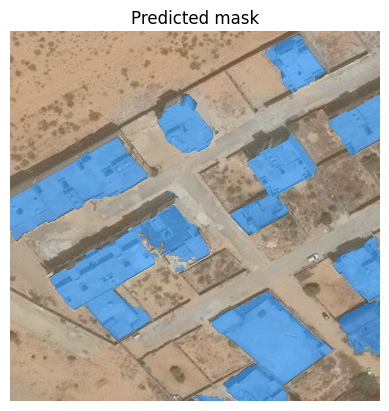

In [23]:
fig, axes = plt.subplots()

sam_seg_prob = binary_mask.cpu().numpy().squeeze()
axes.imshow(np.array(image))
show_mask(sam_seg_prob, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 499.5, 499.5, -0.5)

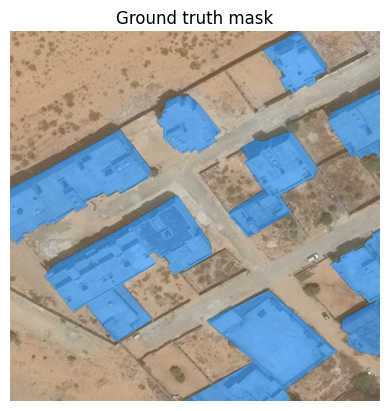

In [24]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask.reshape(1, 500, 500), axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")